# Metrics

## Import dependencies

In [28]:
import json
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import shutil
import math
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc
import subprocess
import csv
import seaborn as sns

## Preprocessing dataset

## Load dataset

In [29]:
DATA_SET_PATH = '/media/rodri/Files/Datasets/Roboflow_v11/Dataset'
DATA_SET_PATH

'/media/rodri/Files/Datasets/Roboflow_v11/Dataset'

## Generate predictions json

In [30]:
## Model variables
ROBOFLOW_MODELS = [
    'yolov5', # 1
    'yolov7', # 2 
    'yolos', # 3 
    'yolov8s', # 4
    'no_version', # 5
    'no_version', # 6
    'error_uploading', # 7
    'yolov5s_data_augmentation', # 8
    'yolov5n_data_augmentation', # 9
]

MODEL_VERSION = 2

# Create and set output path
os.makedirs(os.path.join(DATA_SET_PATH, 'reports', ROBOFLOW_MODELS[MODEL_VERSION-1], 'metrics'), exist_ok=True)

OUTPUT_PATH = os.path.join(DATA_SET_PATH, 'reports', ROBOFLOW_MODELS[MODEL_VERSION-1], 'metrics')

In [31]:
BASE_CURL = 'base64 ${file} | curl -d "@-" "http://localhost:9001/thesis-gun-knife/{{MODEL_VERSION}}?api_key=DmyTMwALZb1Ah6cKptuz"'
BASE_CURL = BASE_CURL.replace('{{MODEL_VERSION}}', str(MODEL_VERSION))
BASE_CURL

'base64 ${file} | curl -d "@-" "http://localhost:9001/thesis-gun-knife/2?api_key=DmyTMwALZb1Ah6cKptuz"'

## Read images

In [32]:
def images_generator_path(images_path:str) -> str:
    """ Read images from a given path using opencv

    Args:
        images_path (str): Path to images

    Yields:
        str: Image path
    """
    for file in tqdm(os.listdir(images_path), desc='Reading images'):
        yield file
        
def get_annotations_from_image(image: str) -> list:
    """ Get annotations from images

    Args:
        model (ObjectDetectionModel): Model to use
        image (str): Image path to predict
        
    Returns:
        list: List of annotations
    """
    annotations = []
    annotations = subprocess.check_output(BASE_CURL.replace('${file}', image), shell=True)
    try:
        annotations = json.loads(annotations)
        annotations = annotations['predictions']
    except Exception as e:
        annotations = []
        print(f'Error: {e} in file {image}')
        raise StopIteration
        
    def convert_yolo_prediction_to_voc(annotations: list)->list:
        new_annotations = []
        try:
            assert len(annotations) > 0, 'No annotations'
            for annotation in annotations:            
                class_id = annotation['class']
                
                x = annotation['x']
                y = annotation['y']
                w = annotation['width']
                h = annotation['height']
                
                xmin = math.floor(x - (w / 2)+1)
                ymin = math.floor(y - (h / 2)+1)
                xmax = math.floor(x + (w / 2)+1)
                ymax = math.floor(y + (h / 2)+1)
                
                new_annotations.append({
                    'path': image,
                    'class': 2 if class_id == 'knife' else (1 if class_id == 'gun' else 0),
                    'bbox':{
                        'xmin': xmin,
                        'ymin': ymin,
                        'xmax': xmax,
                        'ymax': ymax
                    },
                    'conf': annotation['confidence']
                })
            
            return new_annotations
        except AssertionError:
            return [
                {
                    'path': image,
                    'class': 0,
                    'bbox':{
                        'xmin': 0,
                        'ymin': 0,
                        'xmax': 0,
                        'ymax': 0
                    },
                    'conf': 0
                }
            ]

    return convert_yolo_prediction_to_voc(annotations)
    

# Test case
image_path = '/media/rodri/Files/Datasets/Roboflow_v11/Dataset/test/images/101516494_5781_jpg.rf.90ba3800fa4ed5e25aa2ed5b3dbbc221.jpg'
annotations = get_annotations_from_image(image_path)
print(annotations)
image_path = '/media/rodri/Files/Datasets/Roboflow_v11/Dataset/test/images/000000002466.jpg'
annotations = get_annotations_from_image(image_path)
print(annotations)
image_path = '/media/rodri/Files/Datasets/Roboflow_v11/Dataset/test/images/11_12_1565_jpg.rf.95d9be65da98b4d65450e527aec902ba.jpg'
annotations = get_annotations_from_image(image_path)
print(annotations)
image_path = '/media/rodri/Files/Datasets/Roboflow_v11/Dataset/test/images/batch_40_jpg.rf.d083c576c8cf66569711b7eab35f2df5.jpg'
annotations = get_annotations_from_image(image_path)
print(annotations)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 93304    0     0  100 93304      0   7634  0:00:12  0:00:12 --:--:--     0

In [ ]:
TEST_SET_PATH = os.path.join(DATA_SET_PATH, 'test/images')

In [ ]:
test_predictions = []
for path in tqdm(images_generator_path(TEST_SET_PATH), desc='Predicting images', total=1294):
    # print('Image path:', path)
    annotations = get_annotations_from_image(os.path.join(TEST_SET_PATH, path))
    # print('Annotations', end=': ')
    # print(annotations)
    test_predictions.append(annotations)

Predicting images:   0%|          | 0/1294 [00:00<?, ?it/s]  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  232k  100    91  100  232k    192   490k --:--:-- --:--:-- --:--:--  489k
Predicting images:   0%|          | 1/1294 [00:00<11:53,  1.81it/s]  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  146k  100   275  100  146k    541   288k --:--:-- --:--:-- --:--:--  288k
Predicting images:   0%|          | 2/1294 [00:01<12:09,  1.77it/s]  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  304k  100    91  100  304k    159   535k --:--:-- --:--:-- --:--:--  535k
Predicting images:   0%|          | 3/1294 [00:01<12:47,  1.68it/s]  % Total    % Received % Xfe

## Save predictions as json files

In [ ]:
json.dump(test_predictions, open(os.path.join(OUTPUT_PATH, 'predictions.json'), 'w'))
shutil.copy(os.path.join(DATA_SET_PATH, 'test_labels.json'), os.path.join(OUTPUT_PATH, 'test_labels.json'))

'/media/rodri/Files/Datasets/Roboflow_v11/Dataset/reports/yolov5/metrics/test_labels.json'

## Fix json

In [ ]:
test_labels = json.load(open(os.path.join(OUTPUT_PATH, 'test_labels.json'), 'r'))
test_predictions = json.load(open(os.path.join(OUTPUT_PATH, 'predictions.json'), 'r'))

### Convert annotation path from labels to image path

In [ ]:
def convert_label_path_to_image_path(json: list) -> list:
    """ Convert label path to image path

    Args:
        json (list): Json to convert

    Returns:
        list: Converted json
    """
    for item in tqdm(json, desc='Converting label path to image path'):
        for subitem in item:
            subitem['path'] = (subitem['path'].replace('labels', 'images'))[:-3] + 'jpg'
    return json

# Before
print(test_labels[5:])

# Test case
print(convert_label_path_to_image_path(test_labels[5:]))

[[{'path': '/media/rodri/Files/Datasets/Roboflow_v11/Dataset/test/images/000000010023.jpg', 'class': 0, 'bbox': {'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}}], [{'path': '/media/rodri/Files/Datasets/Roboflow_v11/Dataset/test/images/000000010701.jpg', 'class': 0, 'bbox': {'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}}], [{'path': '/media/rodri/Files/Datasets/Roboflow_v11/Dataset/test/images/000000022056.jpg', 'class': 0, 'bbox': {'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}}], [{'path': '/media/rodri/Files/Datasets/Roboflow_v11/Dataset/test/images/000000023687.jpg', 'class': 0, 'bbox': {'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}}], [{'path': '/media/rodri/Files/Datasets/Roboflow_v11/Dataset/test/images/000000024414.jpg', 'class': 0, 'bbox': {'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}}], [{'path': '/media/rodri/Files/Datasets/Roboflow_v11/Dataset/test/images/000000031082.jpg', 'class': 0, 'bbox': {'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}}], [{'path': '/media/rodri/Files/Datasets/Robofl

Converting label path to image path: 100%|██████████| 1289/1289 [00:00<00:00, 664837.41it/s]

[[{'path': '/media/rodri/Files/Datasets/Roboflow_v11/Dataset/test/images/000000010023.jpg', 'class': 0, 'bbox': {'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}}], [{'path': '/media/rodri/Files/Datasets/Roboflow_v11/Dataset/test/images/000000010701.jpg', 'class': 0, 'bbox': {'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}}], [{'path': '/media/rodri/Files/Datasets/Roboflow_v11/Dataset/test/images/000000022056.jpg', 'class': 0, 'bbox': {'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}}], [{'path': '/media/rodri/Files/Datasets/Roboflow_v11/Dataset/test/images/000000023687.jpg', 'class': 0, 'bbox': {'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}}], [{'path': '/media/rodri/Files/Datasets/Roboflow_v11/Dataset/test/images/000000024414.jpg', 'class': 0, 'bbox': {'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}}], [{'path': '/media/rodri/Files/Datasets/Roboflow_v11/Dataset/test/images/000000031082.jpg', 'class': 0, 'bbox': {'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}}], [{'path': '/media/rodri/Files/Datasets/Robofl

In [ ]:
test_labels = convert_label_path_to_image_path(test_labels)

Converting label path to image path: 100%|██████████| 1294/1294 [00:00<00:00, 618369.53it/s]


### Save results as json files on metrics folder

In [ ]:
json.dump(test_labels, open(os.path.join(OUTPUT_PATH, 'test_labels.json'), 'w'))

## Merge annotations from all json files into a csv file

The columns are:
- image_path
- true class
- predicted class
- bbox_true
- bbox_predicted
- IoU
- confidence

In [ ]:
def merge_predictions_and_labels(predictions: list, labels: list) -> list:
    """ Merge predictions and labels

    Problem:
        - One path in predictions can have multiple labels
        - One path in labels can have multiple predictions

    Solution:
        - For each unique path in predictions:
            - Get all predictions and labels with that path
            - Merge them into a single dict considering the following cases:
                - Predictions have more annotations than labels
                    - In this case, complete the labels with 0s
                - Labels have more annotations than predictions
                    - In this case, complete the predictions with 0s

    Args:
        predictions (list): Predictions
        labels (list): Labels

    Returns:
        list: Merged predictions and labels
    """
    merged = []
    for prediction, label in tqdm(zip(predictions, labels), desc='Merging predictions and labels', total=len(predictions)):    
        ## Case: len(prediction) > len(label)
        if len(prediction) > len(label):
            label = [*label, *[{
                'path': label[0]['path'],
                'class': 0,
                'bbox':{
                    'xmin': 0,
                    'ymin': 0,
                    'xmax': 0,
                    'ymax': 0
                },
            }]*(len(prediction) - len(label))]        
            
        ## Case: len(prediction) < len(label)
        elif len(prediction) < len(label):
            prediction = [*prediction, *[{
                'path': prediction[0]['path'],
                'class': 0,
                'bbox':{
                    'xmin': 0,
                    'ymin': 0,
                    'xmax': 0,
                    'ymax': 0
                },
                'conf': 0
            }]*(len(label) - len(prediction))]
            
        ## Merge
        for pred, lab in zip(prediction, label):
            merged.append({
                'path': pred['path'],
                'pred': {
                    'class': pred['class'],
                    'bbox': pred['bbox'],
                    'conf': pred['conf']
                },
                'lab': {
                    'class': lab['class'],
                    'bbox': lab['bbox'],
                }
            })
        
    return merged
        
# Test cases
predictions_head = test_predictions[:50]
labels_head = test_labels[:50]

merged = merge_predictions_and_labels(predictions_head, labels_head)
print("Merged:", end=' ')
print(json.dumps(merged, indent=4))


Merging predictions and labels: 100%|██████████| 50/50 [00:00<00:00, 82467.64it/s]

Merged: [
    {
        "path": "/media/rodri/Files/Datasets/Roboflow_v11/Dataset/test/images/000000002466.jpg",
        "pred": {
            "class": 0,
            "bbox": {
                "xmin": 0,
                "ymin": 0,
                "xmax": 0,
                "ymax": 0
            },
            "conf": 0
        },
        "lab": {
            "class": 0,
            "bbox": {
                "xmin": 0,
                "ymin": 0,
                "xmax": 0,
                "ymax": 0
            }
        }
    },
    {
        "path": "/media/rodri/Files/Datasets/Roboflow_v11/Dataset/test/images/000000005115.jpg",
        "pred": {
            "class": 1,
            "bbox": {
                "xmin": 620,
                "ymin": 304,
                "xmax": 640,
                "ymax": 347
            },
            "conf": 0.478
        },
        "lab": {
            "class": 0,
            "bbox": {
                "xmin": 0,
                "ymin": 0,
                

In [ ]:
print("Merged:", end=' ')
print(json.dumps(merged, indent=4))

Merged: [
    {
        "path": "/media/rodri/Files/Datasets/Roboflow_v11/Dataset/test/images/000000002466.jpg",
        "pred": {
            "class": 0,
            "bbox": {
                "xmin": 0,
                "ymin": 0,
                "xmax": 0,
                "ymax": 0
            },
            "conf": 0
        },
        "lab": {
            "class": 0,
            "bbox": {
                "xmin": 0,
                "ymin": 0,
                "xmax": 0,
                "ymax": 0
            }
        }
    },
    {
        "path": "/media/rodri/Files/Datasets/Roboflow_v11/Dataset/test/images/000000005115.jpg",
        "pred": {
            "class": 1,
            "bbox": {
                "xmin": 620,
                "ymin": 304,
                "xmax": 640,
                "ymax": 347
            },
            "conf": 0.478
        },
        "lab": {
            "class": 0,
            "bbox": {
                "xmin": 0,
                "ymin": 0,
                

In [ ]:
# Specific image
image_path = '/media/rodri/Files/Datasets/Roboflow_v11/Dataset/test/images/batch_40_jpg.rf.d083c576c8cf66569711b7eab35f2df5.jpg'

label = [item for item in test_labels if item[0]['path'] == image_path]
print("Label:", end=' ')
print(json.dumps(label, indent=4))

prediction = [item for item in test_predictions if item[0]['path'] == image_path]
print("Prediction:", end=' ')
print(json.dumps(prediction, indent=4))

Label: [
    [
        {
            "path": "/media/rodri/Files/Datasets/Roboflow_v11/Dataset/test/images/batch_40_jpg.rf.d083c576c8cf66569711b7eab35f2df5.jpg",
            "class": 1,
            "bbox": {
                "xmin": 2,
                "ymin": 5,
                "xmax": 312,
                "ymax": 314
            }
        },
        {
            "path": "/media/rodri/Files/Datasets/Roboflow_v11/Dataset/test/images/batch_40_jpg.rf.d083c576c8cf66569711b7eab35f2df5.jpg",
            "class": 1,
            "bbox": {
                "xmin": 397,
                "ymin": 68,
                "xmax": 610,
                "ymax": 297
            }
        },
        {
            "path": "/media/rodri/Files/Datasets/Roboflow_v11/Dataset/test/images/batch_40_jpg.rf.d083c576c8cf66569711b7eab35f2df5.jpg",
            "class": 1,
            "bbox": {
                "xmin": 8,
                "ymin": 322,
                "xmax": 314,
                "ymax": 629
            }
    

In [ ]:
merged_data = merge_predictions_and_labels(test_predictions, test_labels)
print("Merged data:", end=' ')
print(json.dumps(merged_data[:5], indent=4))

Merging predictions and labels: 100%|██████████| 1294/1294 [00:00<00:00, 262562.50it/s]

Merged data: [
    {
        "path": "/media/rodri/Files/Datasets/Roboflow_v11/Dataset/test/images/000000002466.jpg",
        "pred": {
            "class": 0,
            "bbox": {
                "xmin": 0,
                "ymin": 0,
                "xmax": 0,
                "ymax": 0
            },
            "conf": 0
        },
        "lab": {
            "class": 0,
            "bbox": {
                "xmin": 0,
                "ymin": 0,
                "xmax": 0,
                "ymax": 0
            }
        }
    },
    {
        "path": "/media/rodri/Files/Datasets/Roboflow_v11/Dataset/test/images/000000005115.jpg",
        "pred": {
            "class": 1,
            "bbox": {
                "xmin": 620,
                "ymin": 304,
                "xmax": 640,
                "ymax": 347
            },
            "conf": 0.478
        },
        "lab": {
            "class": 0,
            "bbox": {
                "xmin": 0,
                "ymin": 0,
           

### Convert to csv

In [ ]:
def write_merged_data_into_csv(merged_data: list, csv_path: str) -> None:
    """ Write merged data into csv

    Args:
        merged_data (list): Merged data
        csv_path (str): Csv path
    """
    
    def get_iou(boxA: list, boxB: list) -> float:
        """ Calculate IoU

        Args:
            boxA (list): Box A
            boxB (list): Box B

        Returns:
            float: IoU
        """
        # determine the (x, y)-coordinates of the intersection rectangle
        xA = max(boxA[0], boxB[0])
        yA = max(boxA[1], boxB[1])
        xB = min(boxA[2], boxB[2])
        yB = min(boxA[3], boxB[3])
    
        # compute the area of intersection rectangle
        interArea = max(0, xB - xA) * max(0, yB - yA)
    
        # compute the area of both the prediction and ground-truth
        # rectangles
        boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
        boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    
        # compute the intersection over union by taking the intersection
        # area and dividing it by the sum of prediction + ground-truth
        # areas - the interesection area
        try:
            return interArea / float(boxAArea + boxBArea - interArea)
        except ZeroDivisionError:
            return 0.0
    
    with open(csv_path, 'w') as csv_file:
        csv_writer = csv.writer(csv_file)
        csv_writer.writerow(['path', 'true_class', 'predicted_class', 'xmin_true', 'ymin_true', 'xmax_true', 'ymax_true', 'xmin_predicted', 'ymin_predicted', 'xmax_predicted', 'ymax_predicted', 'iou', 'confidence'])
        for item in tqdm(merged_data, desc='Writing merged data into csv'):
            csv_writer.writerow([
                item['path'],
                item['lab']['class'],
                item['pred']['class'],
                item['lab']['bbox']['xmin'],
                item['lab']['bbox']['ymin'],
                item['lab']['bbox']['xmax'],
                item['lab']['bbox']['ymax'],
                item['pred']['bbox']['xmin'],
                item['pred']['bbox']['ymin'],
                item['pred']['bbox']['xmax'],
                item['pred']['bbox']['ymax'],
                get_iou(
                    boxA=[
                        item['lab']['bbox']['xmin'],
                        item['lab']['bbox']['ymin'],
                        item['lab']['bbox']['xmax'],
                        item['lab']['bbox']['ymax']
                    ],
                    boxB=[
                        item['pred']['bbox']['xmin'],
                        item['pred']['bbox']['ymin'],
                        item['pred']['bbox']['xmax'],
                        item['pred']['bbox']['ymax']
                    ]    
                ),
                item['pred']['conf']
            ])
            
write_merged_data_into_csv(merged_data, os.path.join(DATA_SET_PATH, 'metrics', 'merged.csv'))

Writing merged data into csv: 100%|██████████| 1656/1656 [00:00<00:00, 48561.95it/s]


## Getting metrics from csv file using pandas

### Summary

In [ ]:
df = pd.read_csv(os.path.join(DATA_SET_PATH, 'metrics', 'merged.csv'))
df.head()

,path,true_class,predicted_class,xmin_true,ymin_true,xmax_true,ymax_true,xmin_predicted,ymin_predicted,xmax_predicted,ymax_predicted,iou,confidence
0,/media/rodri/Files/Datasets/Roboflow_v11/Datas...,0,0,0,0,0,0,0,0,0,0,0.0,0.000
1,/media/rodri/Files/Datasets/Roboflow_v11/Datas...,0,1,0,0,0,0,620,304,640,347,0.0,0.478
2,/media/rodri/Files/Datasets/Roboflow_v11/Datas...,0,0,0,0,0,0,0,0,0,0,0.0,0.000
3,/media/rodri/Files/Datasets/Roboflow_v11/Datas...,0,0,0,0,0,0,0,0,0,0,0.0,0.000
4,/media/rodri/Files/Datasets/Roboflow_v11/Datas...,0,1,0,0,0,0,386,23,430,153,0.0,0.539


(array([  1.,   2.,   3.,   1.,   0.,   3.,   1.,   4.,   4.,   7.,  15.,
         16.,  45.,  39.,  70.,  94., 151., 177., 179.,  98.]),
 array([0.00600109, 0.05490739, 0.10381368, 0.15271998, 0.20162627,
        0.25053256, 0.29943886, 0.34834515, 0.39725145, 0.44615774,
        0.49506404, 0.54397033, 0.59287663, 0.64178292, 0.69068922,
        0.73959551, 0.78850181, 0.8374081 , 0.88631439, 0.93522069,
        0.98412698]),
 <BarContainer object of 20 artists>)

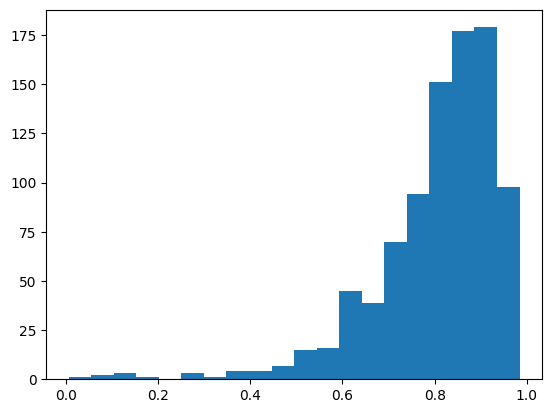

In [ ]:
# IoU Histogram
iou_no_zeros = [x for x in df['iou'] if x > 0]
plt.hist(iou_no_zeros, bins=20)

(array([ 4.,  2.,  2.,  6.,  2.,  6.,  4.,  4.,  3.,  2.,  2.,  7.,  5.,
         6.,  4.,  4.,  8.,  3.,  6.,  1.,  2.,  3.,  1.,  4.,  6.,  4.,
         4.,  8.,  2.,  7.,  0.,  1.,  2.,  3.,  3.,  2.,  2.,  5.,  6.,
         5.,  4.,  5.,  1.,  9.,  8.,  6.,  2.,  4.,  5.,  8.,  6.,  7.,
         4.,  6.,  6.,  6.,  4.,  9.,  5., 12., 10., 14., 11., 12., 16.,
        13., 12., 21., 22., 16., 19., 24., 22., 16., 24., 15., 19., 30.,
        32., 23., 23., 43., 25., 46., 47., 49., 40., 54., 50., 29., 47.,
        26., 45., 35., 59., 34., 23., 14.,  5.,  8.]),
 array([0.401  , 0.40654, 0.41208, 0.41762, 0.42316, 0.4287 , 0.43424,
        0.43978, 0.44532, 0.45086, 0.4564 , 0.46194, 0.46748, 0.47302,
        0.47856, 0.4841 , 0.48964, 0.49518, 0.50072, 0.50626, 0.5118 ,
        0.51734, 0.52288, 0.52842, 0.53396, 0.5395 , 0.54504, 0.55058,
        0.55612, 0.56166, 0.5672 , 0.57274, 0.57828, 0.58382, 0.58936,
        0.5949 , 0.60044, 0.60598, 0.61152, 0.61706, 0.6226 , 0.62814,
        

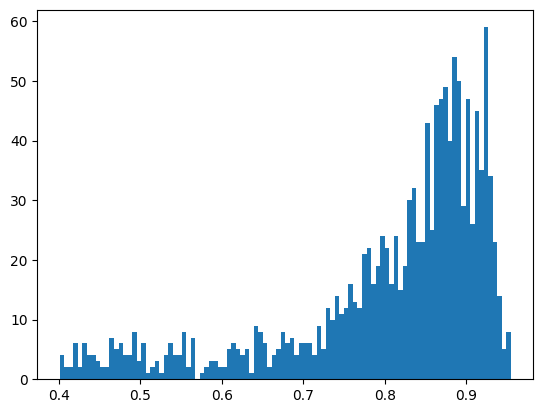

In [ ]:
# Confidence
conf_no_zeros = [x for x in df['confidence'] if x > 0]
plt.hist(conf_no_zeros, bins=100)

In [ ]:
# Pd dataframe summary
df.describe()

,true_class,predicted_class,xmin_true,ymin_true,xmax_true,ymax_true,xmin_predicted,ymin_predicted,xmax_predicted,ymax_predicted,iou,confidence
count,1656.000000,1656.000000,1656.000000,1656.00000,1656.000000,1656.000000,1656.000000,1656.000000,1656.000000,1656.000000,1656.000000,1656.000000
mean,1.161232,1.194444,181.605676,196.93901,287.643720,340.969807,193.564010,203.361111,301.081522,348.337560,0.442414,0.652017
std,0.767918,0.733072,159.108285,173.64964,202.391439,224.010426,163.403675,174.318762,199.833447,218.803931,0.412917,0.336443
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,-19.000000,-8.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,5.750000,6.00000,122.000000,167.000000,9.000000,9.750000,150.000000,189.000000,0.000000,0.543750
50%,1.000000,1.000000,168.500000,174.00000,305.000000,392.500000,182.000000,180.000000,314.000000,393.000000,0.624621,0.814500
75%,2.000000,2.000000,301.000000,341.00000,455.000000,536.000000,314.000000,354.250000,457.250000,536.000000,0.847675,0.884000
max,2.000000,2.000000,601.000000,593.00000,641.000000,641.000000,620.000000,617.000000,656.000000,652.000000,0.984127,0.955000


## Getting metrics from csv file using pandas and sklearn

<Axes: xlabel='Predicted', ylabel='True'>

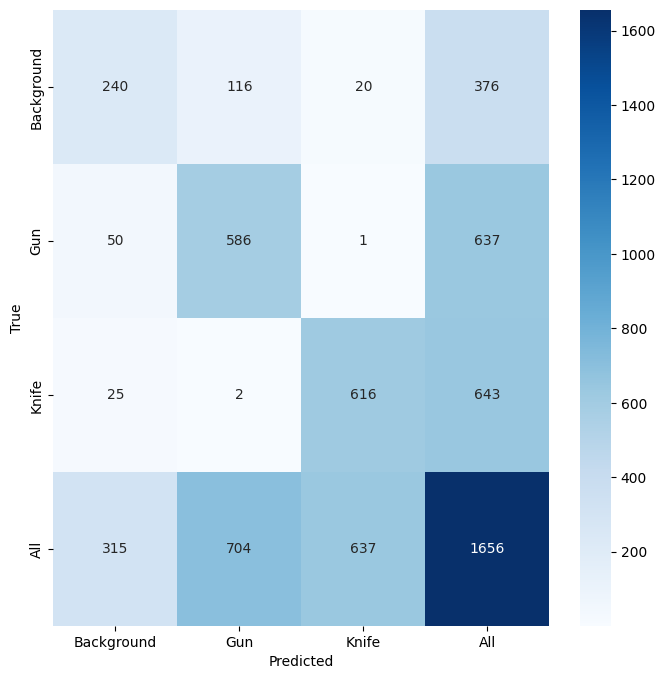

In [ ]:
## Confusion matrix
confusion_matrix = pd.crosstab(df['true_class'], df['predicted_class'], rownames=['True'], colnames=['Predicted'], margins=True)
plt.figure(figsize=(8, 8))

# Change axes by classnames: ['Background', 'Gun, 'Knife']
confusion_matrix = confusion_matrix.rename(columns={0: 'Background', 1: 'Gun', 2: 'Knife', 3: 'All'})
confusion_matrix = confusion_matrix.rename(index={0: 'Background', 1: 'Gun', 2: 'Knife', 3: 'All'})

sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')

<Axes: xlabel='Predicted', ylabel='True'>

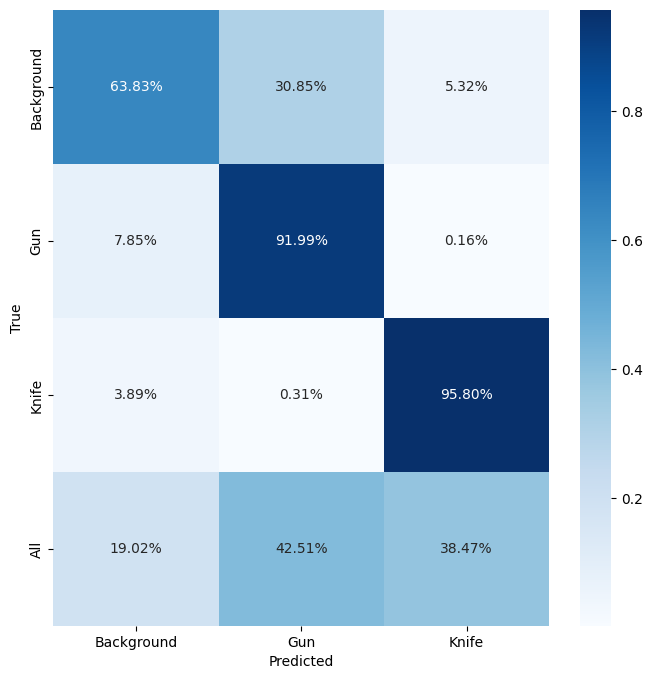

In [ ]:
# Confusion matrix percentage
confusion_matrix_percentage = pd.crosstab(df['true_class'], df['predicted_class'], rownames=['True'], colnames=['Predicted'], margins=True, normalize='index')
plt.figure(figsize=(8, 8))

# Change axes by classnames: ['Background', 'Gun, 'Knife']
confusion_matrix_percentage = confusion_matrix_percentage.rename(columns={0: 'Background', 1: 'Gun', 2: 'Knife', 3: 'All'})
confusion_matrix_percentage = confusion_matrix_percentage.rename(index={0: 'Background', 1: 'Gun', 2: 'Knife', 3: 'All'})

sns.heatmap(confusion_matrix_percentage, annot=True, fmt='.2%', cmap='Blues')

In [ ]:
# Classification report
report = classification_report(df['true_class'], df['predicted_class'], target_names=['Background', 'Gun', 'Knife'])
print(report)

              precision    recall  f1-score   support

  Background       0.76      0.64      0.69       376
         Gun       0.83      0.92      0.87       637
       Knife       0.97      0.96      0.96       643

    accuracy                           0.87      1656
   macro avg       0.85      0.84      0.84      1656
weighted avg       0.87      0.87      0.87      1656



In [ ]:
# Get total accuracy, precision, recall and F1 score
total_accuracy = accuracy_score(df['true_class'], df['predicted_class'])
total_f1_score = f1_score(df['true_class'], df['predicted_class'], average='macro')
total_precision = precision_score(df['true_class'], df['predicted_class'], average='macro')
total_recall = recall_score(df['true_class'], df['predicted_class'], average='macro')

# Print as pd dataframe
pd.DataFrame({
    'Accuracy': [total_accuracy],
    'F1 score': [total_f1_score],
    'Precision': [total_precision],
    'Recall': [total_recall]
})


,Accuracy,F1 score,Precision,Recall
0,0.870773,0.843707,0.853775,0.838748


In [ ]:
# Get FPS
number_of_frames = len(df)
time_spent = '0:12:47'

def get_fps(number_of_frames: int, time_spent: str) -> float:
    """ Get FPS

    Args:
        number_of_frames (int): Number of frames
        time_spent (str): Time spent

    Returns:
        float: FPS
    """
    time_spent = time_spent.split(':')
    hours = int(time_spent[0])
    minutes = int(time_spent[1])
    seconds = int(time_spent[2])
    total_seconds = hours * 3600 + minutes * 60 + seconds
    return number_of_frames / total_seconds

print(get_fps(number_of_frames, time_spent), 'FPS using YOLOv5s on a CPU')

2.1590612777053453 FPS using YOLOv5s on a CPU


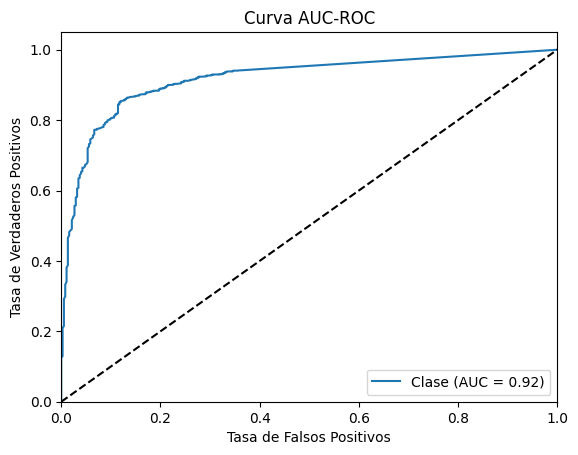

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Obtener las predicciones de probabilidad del modelo
y_true = [1 if x>0 else 0 for x in df['true_class']]
y_pred_proba = df['confidence']

# Calcular la curva ROC y el área bajo la curva (AUC)
fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, label='Clase (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Línea de referencia
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva AUC-ROC')
plt.legend(loc="lower right")
plt.show()
